&nbsp;

# 16 - Diagnostic dynamique avant apprentissage 

---

&nbsp;

## 1. Introduction

Ce notebook a pour rôle de vérifier que la dynamque sous-jacente des données est cohérente, physiquement plausible et exploitable (avant SciML). Il vient comme une étape de validation avant l'apprentissage des modèles SciML.

L'enjeu central est le suivant. Un modèle d'apprentissage, et plus particulièrement, un réseau de neurones, ne doit pas apprendre une dynamique mal définie ou numériquement instable.

&nbsp;

> #### Pourquoi un diagnostic dynamique ?

Précisément car cela répond au besoin exprimé ci-dessus.

Les approches/modèles SciML cherchent en fait à approximer : 

- Les relations différentielles
- Les champs de vecteurs dynamiques
- Les régimes d'évolution temporels

C'est la force de ce type d'apprentissage. Mais si les données présentent des dérivées mal estimées, des ordres de grandeurs incohérents ou une dynamique dominée par le bruit, alors tout apprentissage provoquerait de perturber grandement la véracité/authenticité de la dynamique de sortie, cela s'accompagnerait de prédictions imprécises.

&nbsp;

---

&nbsp;

## 2. Estimation des dérivées numériques

> #### Les dérivées temporelles sont-elles bien définies ?

Les modèles SciML apprennent souvent des lois différentielles implicites, c'est-à-dire qu'une ou plusieurs variables peuvent être liées à d'autres de manière non-explicite.

Pour vérifier si de mauvaises estimations des dérivées sont d'augures, nous pouvons utiliser certaines méthodes pour estimer les dérivées. Après quelques recherches méthodologiques, l'idée pour estimer semble être de travailler avec plusieurs schémas d'estimations et comparer la cohérence des résultats. On se sert d'une première méthode dite *baseline* comme la *dérivation par différences finies centrées* (voir https://imag.umontpellier.fr/~nicoud/Cours/CSI%20-%20differences%20finies.pdf) (erreur d'approximation relativement importante).


### 2.1 Dérivation par différeces finies centrées

Cette première approximation est volontairement peu mathématiquement sophistiquée pour avoir une estimation de "transition" vers des méthodes plus avancées et s'assurer d'une cohérence à plusieurs niveaux de sophistication.

La dérivation par différences finies centrées de notre dynamique est donnée par la formule suivante :

$$
u'(x) \approx  \frac{u(x+h)-u(x-h)}{2h}
$$

Appliquons la à notre état.



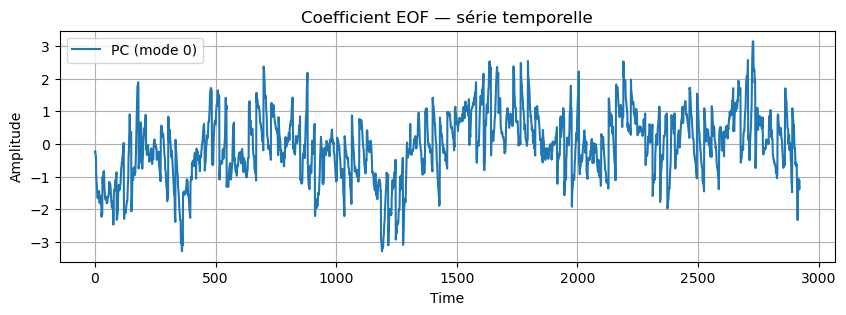

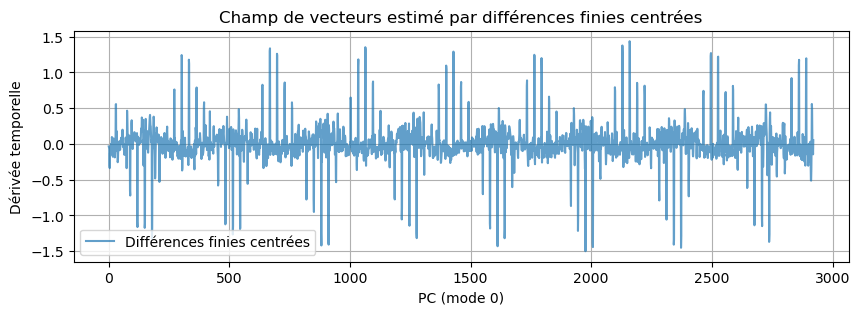

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Basic initialization from the latest processed data
data = np.load("data/processed/sstReducedStateCOPERNICUS20102019Prepared.npz")

PCs = data["PCsTrain"]
t   = data["tTrain"]

dt = float(np.mean(np.diff(t))) # We set the time step (for the derivative scale)

modeId = 0
x = PCs[:, modeId]

dxDtFd = (x[2:] - x[:-2]) / (2 * dt)
tFd = t[1:-1]

plt.figure(figsize=(10, 3))
plt.plot(t, x, label="PC (mode 0)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Coefficient EOF — série temporelle")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(tFd, dxDtFd, label="Différences finies centrées", alpha=0.7)
plt.xlabel("PC (mode 0)")
plt.ylabel("Dérivée temporelle")
plt.title("Champ de vecteurs estimé par différences finies centrées")
plt.legend()
plt.grid(True)
plt.show()

On rappelle la forme de notre premier mode pour comparer avec l'estimation de la dérivée temporelle.

On observe une forte variabilité locale conjuguée avec des pics verticaux. Cela donne un aspect "bruit blanc + spikes". La méthode amplifie naturellement les bruits donc les hautes fréquences provoquent ces amplifications. 

Globalement les pics semblent corrélés aux variations rapides du PC 0, l'ordre de grandeur reste borné, il n'y a ni divergences temporelles ni saturation numérique. La dérivée est bruitée mais structurée et sensibles aux variations du PC, c'est ce qu'on attend d'une baseline.

### 2.2 Filtre de Savitzky-Golay

Comparons avec la forme d'une dérivation "régularisée" comme le filtre de Savitzky-Golay qui va limiter l'impact du bruit.

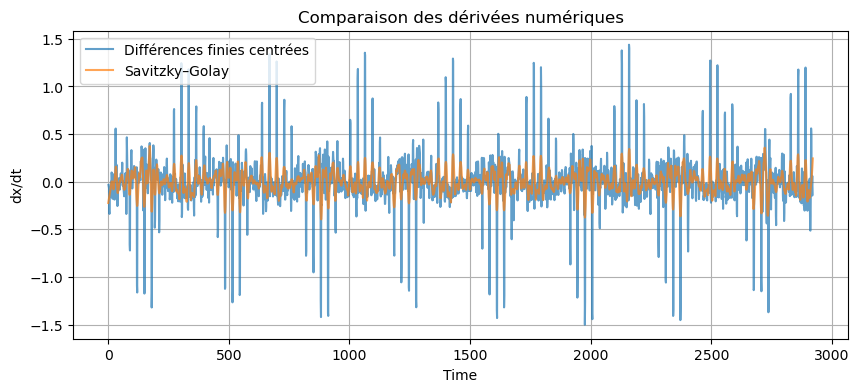

In [12]:
# Apply Savitzky–Golay filter to estimate a second time the derivative with less noise
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html for more details about scipy's implementation

windowLength = 21 # Must be odd and greater than polyorder
polyorder = 3 # Polynomial order used for the local fitting

dxDtSg = savgol_filter(
    x,
    window_length=windowLength,
    polyorder=polyorder,
    deriv=1,
    delta=dt,
)

tSg = t # Same length as original signal (time steps are unchanged)

plt.figure(figsize=(10, 4))
plt.plot(tFd, dxDtFd, label="Différences finies centrées", alpha=0.7)
plt.plot(tSg, dxDtSg, label="Savitzky–Golay", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.title("Comparaison des dérivées numériques")
plt.legend()
plt.grid(True)
plt.show()


> #### Que fait le filtre de Savitzky-Golay ?

C'est un filtre numérique utilisé pour lisser des données bruitées tout en conservant la structure fine. C'est donc une bonne méthode à appliquer par dessus notre baseline.

Mathématiquement, cela consiste à ajuster localement un polynôme (de l'ordre *polyorder* choisi) par moindres carrés à chaque sous-ensembles de point de points adjacents du signal (conditionnés par *windowLength*), avant de calculer sa dérivée analytique (voir https://math.univ-cotedazur.fr/~diener/MAB07/MCO.pdf pour plus de détail sur la méthode des moindres carrés).

Voir la vidéo suivante pour une explication visuelle (https://www.youtube.com/watch?v=1SvDZPvUo_I).

### 2.3 Sensibilité au filtrage

On termine l'estimation par tester la sensibilité de celle-ci aux changements de paramètres de filtrage. On cherche simplement une cohérence pour s'assurer la stabilité numérique de la dynamique est bien posée.

Testons pour plusieurs fenêtres glissantes différentes à appliquer au filtrage.

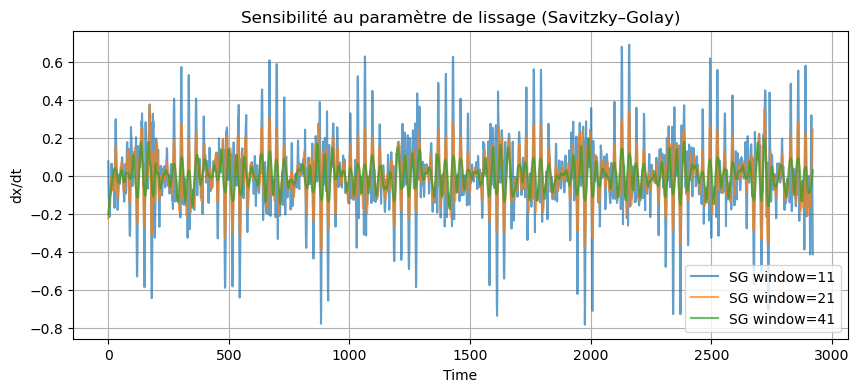

In [13]:
windows = [11, 21, 41]

plt.figure(figsize=(10, 4))

for w in windows:
    dx = savgol_filter(x, window_length=w, polyorder=3, deriv=1, delta=dt)
    plt.plot(t, dx, label=f"SG window={w}", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.title("Sensibilité au paramètre de lissage (Savitzky–Golay)")
plt.legend()
plt.grid(True)
plt.show()


On observe que les grandes structures temporelles sont communes aux trois courbes, correspondant à notre dynamique principale. 

Les différences portent sur l'amplitude et les hautes fréquences. Cela reste cohérent : plus on élargit la fenêtre plus le lissage du bruit est important.

Testons également avec un pas de temps différent.

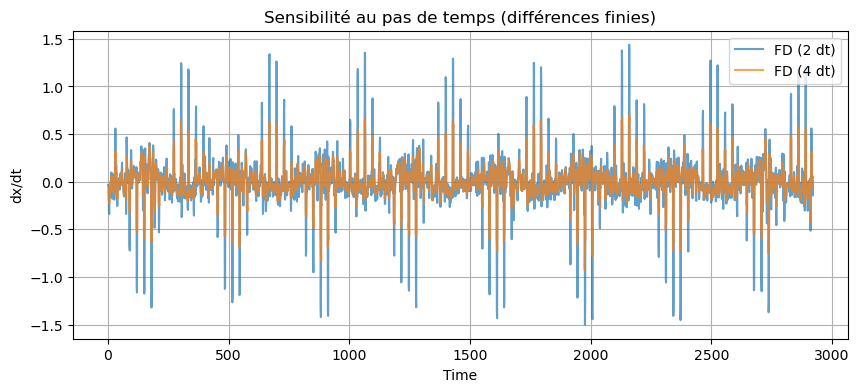

In [14]:
dxDtFdCoarse = (x[4:] - x[:-4]) / (4 * dt)
tFdCoarse = t[2:-2]

plt.figure(figsize=(10, 4))
plt.plot(tFd, dxDtFd, label="FD (2 dt)", alpha=0.7)
plt.plot(tFdCoarse, dxDtFdCoarse, label="FD (4 dt)", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.title("Sensibilité au pas de temps (différences finies)")
plt.legend()
plt.grid(True)
plt.show()


Même constat pour le test avec un pas de temps plus important : bruits et amplitudes qui réduisent. On remarque que même avec le changement de pas il n'y a pas de rupture de régimes, les variations de pics se superposent.

En conclusion, le changement de paramètres n'affecte pas drastiquement la dynamique, les régimes ne changent pas subitement et les amplitudes ne s'effondrent ou n'explosent pas. Les dérivées sont sensibles mais cohérentes. La dynamique est présumée réelle et robuste, l'apprentissage d'un modèle SciML type Neural ODE sur notre état réduit semble donc pertinent.

&nbsp;

---

&nbsp;

## 2. Ordres de grandeur et cohérence physique

> #### Pourquoi analyser les ordres de grandeur ?

Un modèle d'apprentissage SciML, et plus particulièrement un réseau de neurones, est aveugle aux échelles physiques si les contraintes ne sont pas explicites. 

En clair, on peut faire apprendre toute dynamique numériquement correcte, mais si elle est absurde physiquement le modèle sera intrinsèquement faussé. Cela peut arriver si les dérivées sont trop grandes par rapport aux états ou si des dynamiques sont dominées par des fluctuations numériques.

Cette section visera donc à vérifier que les variables d'état et leur dérivées existent sur des échelles "compatibles" et temporellement stables.

&nbsp;

### 2.1 Amplitudes des dérivations

> #### Les amplitudes de $x$, $\dot{x}$ et $\ddot{x}$ sont-elles cohérentes ?

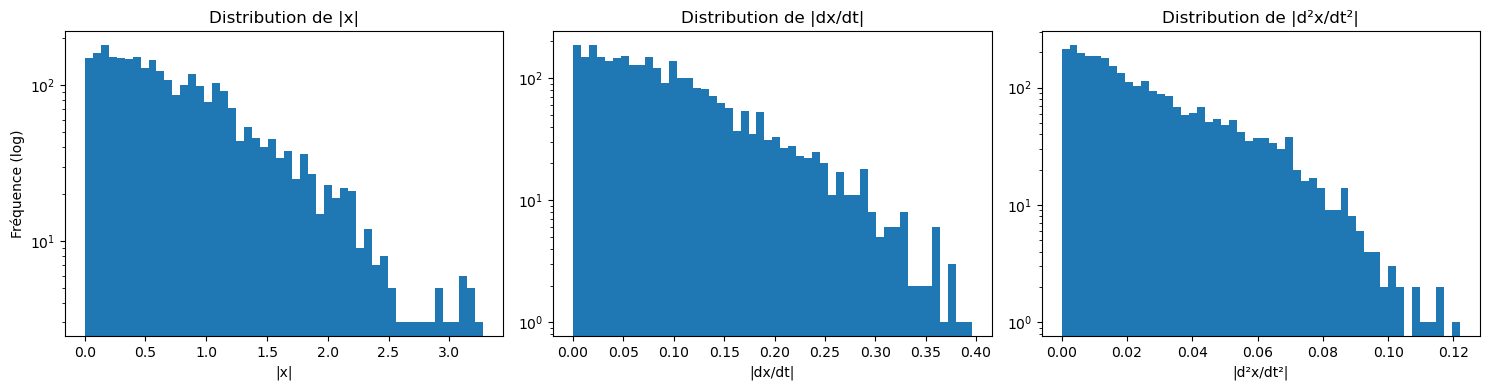

In [27]:
dxDt = dxDtSg
d2xDt2 = np.gradient(dxDt, dt)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(np.abs(x), bins=50, log=True)
plt.xlabel("|x|")
plt.ylabel("Fréquence (log)")
plt.title("Distribution de |x|")

plt.subplot(1, 3, 2)
plt.hist(np.abs(dxDt), bins=50, log=True)
plt.xlabel("|dx/dt|")
plt.title("Distribution de |dx/dt|")

plt.subplot(1, 3, 3)
plt.hist(np.abs(d2xDt2), bins=50, log=True)
plt.xlabel("|d²x/dt²|")
plt.title("Distribution de |d²x/dt²|")

plt.tight_layout()
plt.show()


Les trois histogrammes montrent des signes sains d'une dynamique continue régularisée : 
- Les ordres de grandeur décroissent avec l'ordre de dérivation
- Pas de rupture, dérive ou explosion
- Pas de queue infinie

Le fait que la distribution pour le second ordre de dérivation garde une forme stable et cohérente laisse penser que le bruit est maîtrisé.

&nbsp;

### 2.2 Proportions des états

> #### Les dérivées sont-elles proportionnées aux états, ou numériquement déconnectées ?

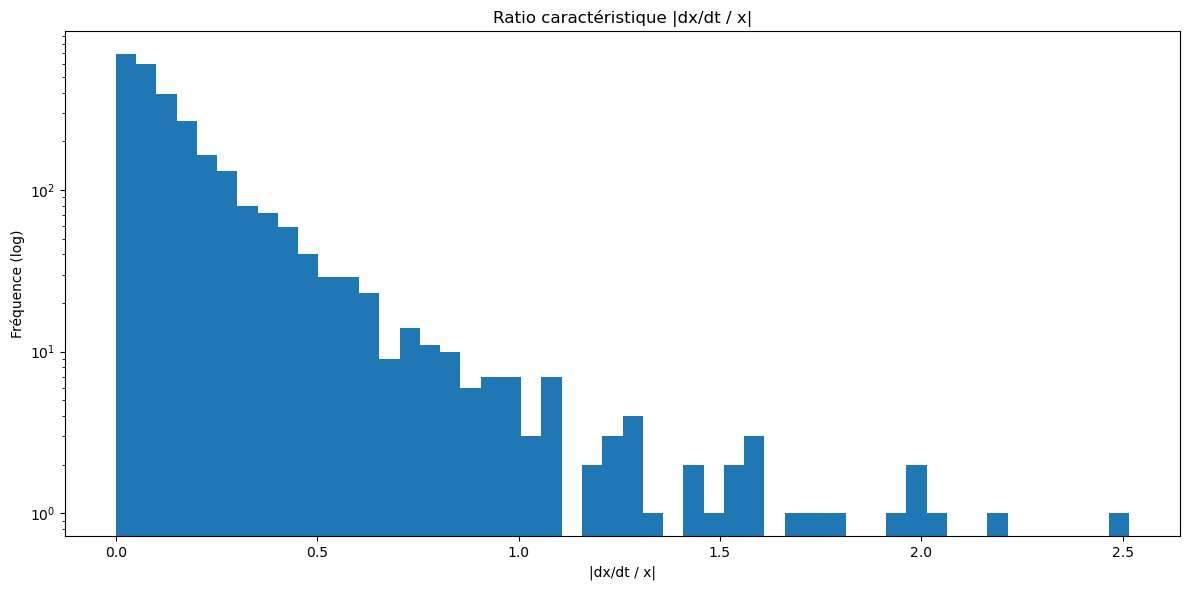

In [26]:
# Before this result, we tried :
# espilon = 1e-8
# ratio = np.abs(dxDt / (x + epsilon))

# We prefer using a mask to avoid artifacts due to division by very small values
mask = np.abs(x) > 0.1 * np.std(x) # Avoid division by very small values so we dont get mathematical artifacts (huge ratios)
ratio = np.abs(dxDt[mask] / x[mask])
ratio2 = np.abs(d2xDt2[mask] / dxDt[mask])

plt.figure(figsize=(12, 6))
plt.hist(np.abs(ratio), bins=50, log=True)
plt.xlabel("|dx/dt / x|")
plt.ylabel("Fréquence (log)")
plt.title("Ratio caractéristique |dx/dt / x|")
plt.tight_layout()
plt.show()


&nbsp;

&nbsp;

### 2.3 Temps caractéristiques

> #### Existe-t-il des temps caractéristiques bien définis ?

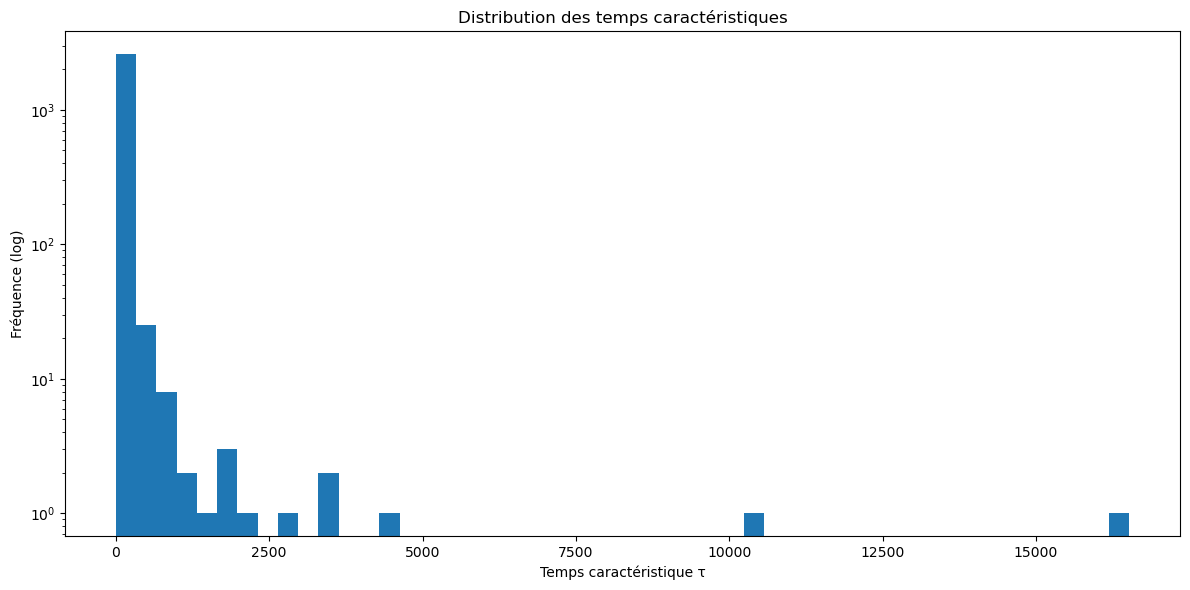

In [25]:
# Same here
tau = np.abs(x[mask] / dxDt[mask])

plt.figure(figsize=(12, 6))
plt.hist(tau, bins=50, log=True)
plt.xlabel("Temps caractéristique τ")
plt.ylabel("Fréquence (log)")
plt.title("Distribution des temps caractéristiques")
plt.tight_layout()
plt.show()


&nbsp;

### 2.4 Échelles temporelles

> #### Ces échelles varient-elles brutalement dans le temps ou restent-elles stables ?

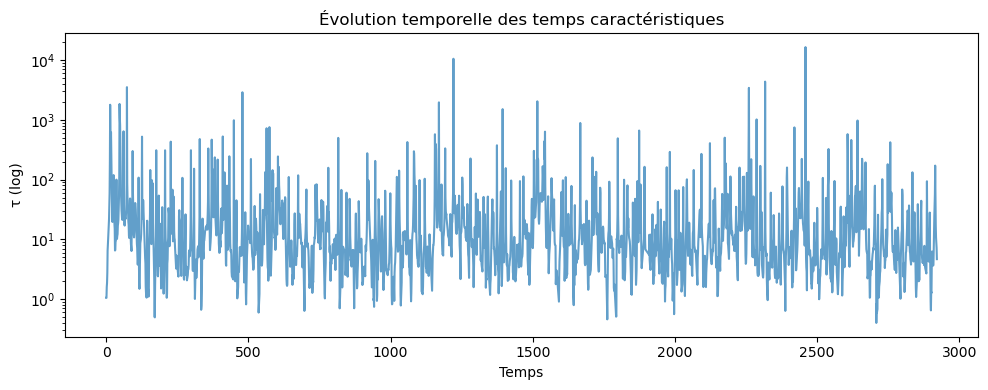

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(t[mask], tau, label="Temps caractéristique τ", alpha=0.7)
plt.yscale("log")
plt.xlabel("Temps")
plt.ylabel("τ (log)")
plt.title("Évolution temporelle des temps caractéristiques")
plt.tight_layout()
plt.show()


&nbsp;

---

&nbsp;

## 3. Visualisation du champs de phase